# Fake News Classification with Recurrent Convolutional Neural Networks

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, use_memory_fs=False, )
import spacy
import en_core_web_md
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Read Data

In [21]:
data = pd.read_csv('./data/combined_news_data.csv')
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74012 entries, 0 to 74783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   74012 non-null  object
 1   text    74012 non-null  object
 2   label   74012 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


## Exploratory Data Analysis

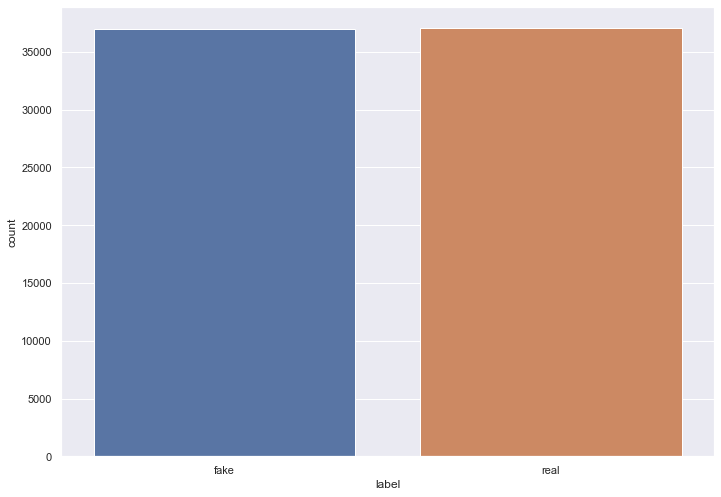

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
conversion_dict = {0: 'real', 1: 'fake'}
sns.countplot(data['label'].apply(lambda x: conversion_dict[x]))

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
data['length'] = data['text'].apply(lambda x: len(x.split(' ')))

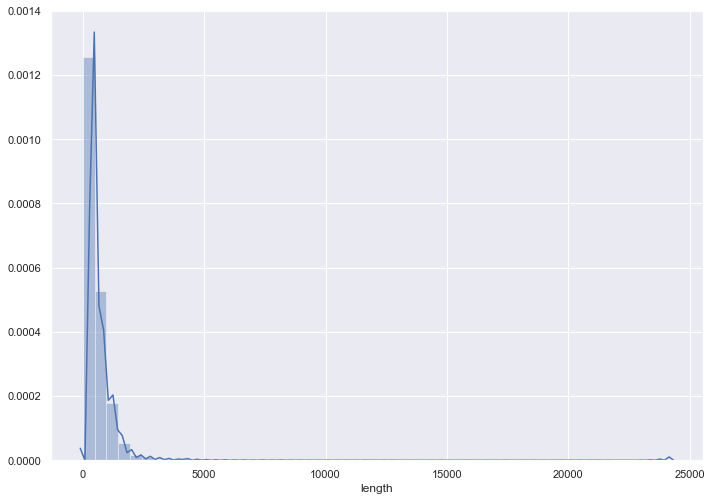

In [24]:
sns.distplot(data['length'])

In [32]:
data['length'].describe()

count    74012.000000
mean       549.869251
std        629.223073
min          1.000000
25%        235.000000
50%        404.000000
75%        672.000000
max      24234.000000
Name: length, dtype: float64

## Preprocessing the Text Data

In [11]:
import re # regex library
from spacy.lang.en.stop_words import STOP_WORDS

nlp = en_core_web_md.load()

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # Effectively removes HTML markup tags
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.text not in STOP_WORDS])
    return text
    
    

In [12]:
X = data['text'].parallel_apply(preprocessor)
y = data['label']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

data_processed = pd.DataFrame({'title': data['title'], 'text': X, 'label': y})
data_processed.to_csv('./data/combined_news_data_processed.csv', index=False)

## Topic Modeling with Latent Dirichlet Allocation

In [19]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import pyLDAvis.sklearn

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

def display_topics_pipeline(pipeline_lda, no_top_words):
    vectorizer = pipeline_lda.steps[0][1]
    lda = pipeline_lda.steps[1][1]
    tf_feature_names = vectorizer.get_feature_names()
    display_topics(lda, tf_feature_names, no_top_words)

### Real News

In [26]:
real_news = data_processed[data_processed['label'] == 1]

num_topics = 10
num_features=5000

vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
lda = LatentDirichletAllocation(n_components=num_topics,
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0)

lda_pipeline = Pipeline([('vectorizer', vectorizer), ('lda', lda)])
lda_pipeline.fit(real_news['text'])

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.95,
                                 max_features=5000, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vo...lary=None)),
                ('lda',
                 LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                                           evaluate_every=-1,
                                           learning_decay=0.7,
                                           learning_method='online',
                         

In [27]:
pyLDAvis.enable_notebook()
data_vectorized = vectorizer.fit_transform(data_processed['text'])
dash = pyLDAvis.sklearn.prepare(lda_pipeline.steps[1][1], data_vectorized, vectorizer, mds='tsne')

In [23]:
pyLDAvis.save_html(dash, 'real_news_lda.html')

### Fake News

In [24]:
fake_news = data_processed[data_processed['label'] == 0]

num_topics = 10
num_features=5000

vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
lda = LatentDirichletAllocation(n_components=num_topics,
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0)

lda_pipeline = Pipeline([('vectorizer', vectorizer), ('lda', lda)])
lda_pipeline.fit(fake_news['text'])

pyLDAvis.enable_notebook()
data_vectorized = vectorizer.fit_transform(data_processed['text'])
dash = pyLDAvis.sklearn.prepare(lda_pipeline.steps[1][1], data_vectorized, vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  19.884913
9       0.648955  71.707100       2        1  12.976330
2      71.019684   9.971006       3        1  11.766349
1       3.785981  33.185135       4        1  11.383208
6     -42.666500  -9.222070       5        1  10.976678
5      -3.621689 -43.526516       6        1  10.668504
3      -3.632402  -4.171708       7        1   7.072110
4     -36.584400  35.804413       8        1   6.338068
7      44.391380  50.615383       9        1   4.998249
8      40.235809 -31.591665      10        1   3.935593, topic_info=              Term           Freq          Total Category  logprob  loglift
4637       treason  151838.000000  151838.000000  Default  30.0000  30.0000
893        clearly   68575.000000   68575.000000  Default  29.0000  29.0000
1554   electricity   41256.000000   41256.000000  Default  28.0000  28.0000
4655         troop   39729.000000   39729.000000  Default  27.0000  27.0000
2175  historically   49999.000000   49999.000000  Default  26.0000  26.0000
...            ...            ...            ...      ...      ...      ...
3792       request    4893.101555   20899.612261  Topic10  -4.9366   1.7832
2624         learn    5041.177246   31413.773625  Topic10  -4.9068   1.4055
3960        saudis    5817.793729  116928.360645  Topic10  -4.7635   0.2345
3503    prevention    4668.560909   63801.113253  Topic10  -4.9836   0.6202
293      alternate    4142.197824   25859.750078  Topic10  -5.1032   1.4036

[763 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1         1  0.190993  000
1         2  0.001419  000
1         3  0.002629  000
1         4  0.032882  000
1         5  0.614667  000
...     ...       ...  ...
4995     10  0.999755   не
4996     10  0.998672   по
4997     10  0.999469   то
4998     10  0.998572  что
4999     10  0.998291  это

[2645 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 3, 2, 7, 6, 4, 5, 8, 9])

In [25]:
pyLDAvis.save_html(dash, 'fake_news_lda.html')

## Defining and Training the Model

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

class LSTM_Text_Classifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, embedding_vector_length, max_seq_length, lstm_layers, batch_size=32, num_epochs=3, use_hash=False,
                dropout=None, conv_params=None):
        
        self.embedding_vector_length = embedding_vector_length
        self.max_seq_length = max_seq_length
        self.lstm_layer_sizes = lstm_layers
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.use_hashing_trick = use_hash
        if not self.use_hashing_trick:
            self.tokenizer = Tokenizer()
        self.dropout = dropout
        self.conv_params = conv_params
        
    
    def _get_word_index(self, word):
        
        try:
            return self.tokenizer.word_index[word]
        except:
            return None
        
    def _text_to_int_sequence(self, text):
        seq = [self._get_word_index(word) for word in text_to_word_sequence(text)]
        return [index for index in seq if index]
        
    def fit(self, X, y, validation_data):
        
        all_X = pd.concat([X, validation_data[0]])
        if self.use_hashing_trick:
            all_words = set()
            for text in all_X:
                new_words = set(text_to_word_sequence(text))
                all_words = all_words.union(new_words)
            self.max_vocab = len(all_words)*1.3
            
            for i in range(len(X)):
                X[i] = hashing_trick(X[i], max_vocab, hash_function='md5')
            X_pad = sequence.pad_sequences(X, maxlen=self.max_seq_length)
            
            X_valid = validation_data[0]
            
            for i in range(len(X_valid)):
                X_valid[i] = hashing_trick(X_valid[i], max_vocab, hash_function='md5')
            X_valid_pad = sequence.pad_sequences(X_valid, maxlen=self.max_seq_length)
        
            y_valid = validation_data[1]
            
        else:    
            print('Fitting Tokenizer...')
            self.tokenizer.fit_on_texts(all_X)
            self.max_vocab = len(self.tokenizer.word_index) + 20
            X = X.apply(self._text_to_int_sequence)
            X_pad = sequence.pad_sequences(X, maxlen=self.max_seq_length)
        
            X_valid = validation_data[0].apply(self._text_to_int_sequence)
            X_valid_pad = sequence.pad_sequences(X_valid, maxlen=self.max_seq_length)
        
            y_valid = validation_data[1]
        
        self.model = Sequential()
        self.model.add(Embedding(self.max_vocab, self.embedding_vector_length, input_length=self.max_seq_length))
            
        if self.conv_params is not None:
            use_pooling = False
            if self.conv_params['pool_size'] is not None:
                use_pooling = True
            
            for i in range(self.conv_params['n_layers']):
                self.model.add(Conv1D(filters=2*(i+1)*self.conv_params['filters'], 
                                      kernel_size=self.conv_params['kernel_size'], 
                                      padding='same', activation='relu'))
                if use_pooling:
                    self.model.add(MaxPooling1D(pool_size=self.conv_params['pool_size']))

            
        if len(self.lstm_layer_sizes) > 1:
            for lstm_layer_size in self.lstm_layer_sizes[:-1]:
                self.model.add(LSTM(lstm_layer_size, return_sequences=True))
                self.model.add(Dropout(self.dropout))
            self.model.add(LSTM(self.lstm_layer_sizes[-1]))
        else:
            self.model.add(LSTM(self.lstm_layer_sizes[0]))
        if self.dropout is not None:
            self.model.add(Dropout(self.dropout))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        early_stopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=1,
                              verbose=2, mode='max')
        
        checkpoint = ModelCheckpoint(filepath='best_model',
                                     monitor='val_accuracy',
                                     mode='max',
                                     save_best_only=True)
        
        callbacks_list = [early_stopping, checkpoint]
        print(self.model.summary())
        
        print('Fitting model...')
        self.model.fit(X_pad, y, validation_data=(X_valid_pad, y_valid), 
                  epochs=self.num_epochs, batch_size=self.batch_size, callbacks=callbacks_list)
        
        
    def predict(self, X):
        
        if type(X) == pd.core.frame.DataFrame or type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        else:
            X = map(X, self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict(X)
        
    def predict_classes(self, X):
        
        if type(X) == pd.core.frame.DataFrame or type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(np.array(X))
        else:
            X = map(X, self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_classes(np.array(X))
    
    def predict_proba(self, X):
        
        if type(X) == pd.core.series.Series:
            X = X.apply(self._text_to_int_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(X)
        elif type(X) == str:
            X = self._text_to_int_sequence(X)
            X = sequence.pad_sequence(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(np.array(X))
        else:
            X = map(X, self._text_to_word_sequence)
            X = sequence.pad_sequences(X, maxlen = self.max_seq_length)
            return self.model.predict_proba(np.array(X))
    
    def load_model(self, file_path):
        
        self.model = load_model(file_path)
    
    def score(self, X, y):
        
        pred = self.predict(X)
        return accuracy_score(y, pred)
    

Using TensorFlow backend.


### Model Training

In [3]:
lstm_classifier = LSTM_Text_Classifier(embedding_vector_length=64, max_seq_length=512, dropout=0.1, 
                                            lstm_layers=[128, 128], batch_size=256, num_epochs=5, use_hash=False,
                                           conv_params={'filters': 128, 
                                                        'kernel_size': 5, 
                                                        'pool_size': 2,
                                                        'n_layers': 3})

In [42]:
lstm_classifier.fit(X_train, y_train, validation_data=(X_valid, y_valid))

Fitting Tokenizer...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 512, 64)           13169920  
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 512, 256)          82176     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 256, 256)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 256, 512)          655872    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 128, 512)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 128, 768)          1966848   
_________________________________________________________________
max_pooling1d_12 (MaxPooling (Non

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 41446 samples, validate on 10362 samples
Epoch 1/5
41446/41446 [==============================] - 43s 1ms/step - loss: 0.2858 - accuracy: 0.8648 - val_loss: 0.1433 - val_accuracy: 0.9505
Epoch 2/5
41446/41446 [==============================] - 42s 1ms/step - loss: 0.0806 - accuracy: 0.9715 - val_loss: 0.1192 - val_accuracy: 0.9543
Epoch 3/5
41446/41446 [==============================] - 43s 1ms/step - loss: 0.0381 - accuracy: 0.9881 - val_loss: 0.1470 - val_accuracy: 0.9527
Epoch 00003: early stopping


## Validation Results

In [4]:
lstm_classifier.load_model('best_model')

/Users/amol/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


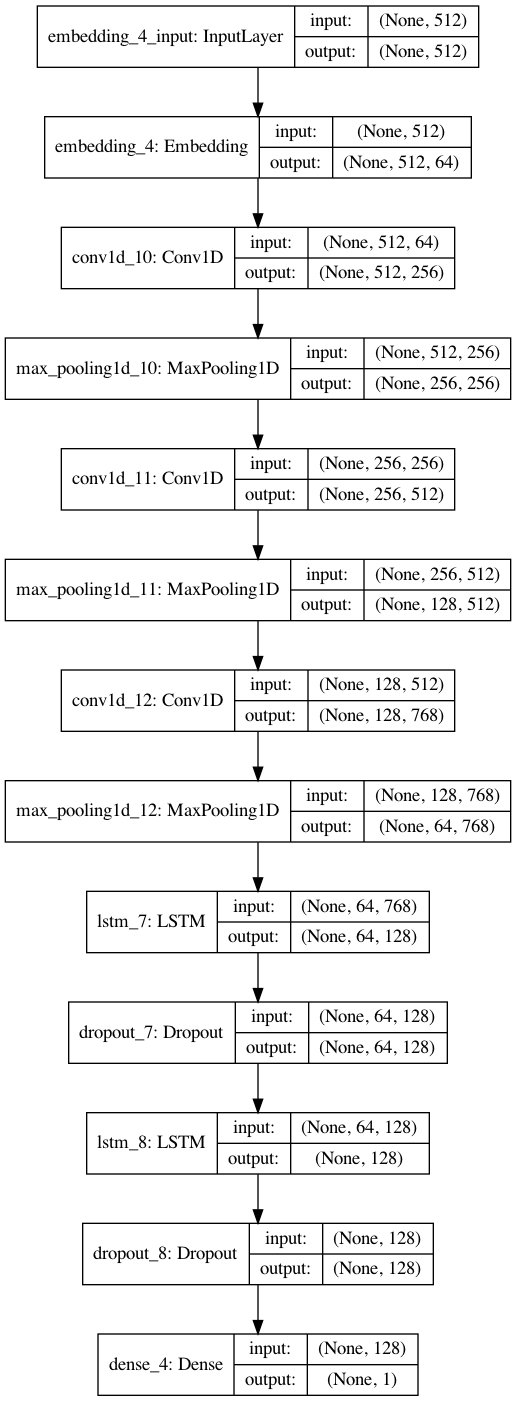

In [6]:
from keras.utils import plot_model
plot_model(
    lstm_classifier.model,
    to_file="recurrent_conv_net.png",
    show_shapes=True,
    show_layer_names=True)

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = lstm_classifier.predict_classes(X_valid)
print(confusion_matrix(y_valid, y_pred))
print(classification_report(y_valid, y_pred, digits=4))

[[4910  204]
 [ 271 4977]]
              precision    recall  f1-score   support

           0     0.9477    0.9601    0.9539      5114
           1     0.9606    0.9484    0.9545      5248

    accuracy                         0.9542     10362
   macro avg     0.9542    0.9542    0.9542     10362
weighted avg     0.9542    0.9542    0.9542     10362



## Testing Results

In [40]:
from sklearn.metrics import accuracy_score

y_pred_test = lstm_classifier.predict_classes(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     11143
           1       0.95      0.94      0.95     11061

    accuracy                           0.95     22204
   macro avg       0.95      0.95      0.95     22204
weighted avg       0.95      0.95      0.95     22204

